# GeoPandas + Census

In [1]:
try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

import numpy as np
import json
from urllib.request import Request, urlopen
import urllib
import pandas as pd
import os
import geopandas as gpd
import shapely
import io
import requests
import matplotlib.pylab as plt
from fiona.crs import from_epsg
%matplotlib inline

## 1.1 Download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [2]:
# download the NYC PUMA data
urllib.request.urlretrieve("https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile", "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7f727f93e7b8>)

In [3]:
# unpack the NYC PUMA data
!unzip file.gz

Archive:  file.gz
  inflating: geo_export_11855b52-5c70-4960-9004-c3bc21f5a6d9.dbf  
  inflating: geo_export_11855b52-5c70-4960-9004-c3bc21f5a6d9.shp  
  inflating: geo_export_11855b52-5c70-4960-9004-c3bc21f5a6d9.shx  
  inflating: geo_export_11855b52-5c70-4960-9004-c3bc21f5a6d9.prj  


In [4]:
# move the files into PUIdata
!mv geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.shp $PUIDATA
!mv geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.dbf $PUIDATA
!mv geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.shx $PUIDATA
!mv geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.prj $PUIDATA

mv: cannot stat 'geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.shp': No such file or directory
mv: cannot stat 'geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.dbf': No such file or directory
mv: cannot stat 'geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.shx': No such file or directory
mv: cannot stat 'geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.prj': No such file or directory


In [5]:
# check and make sure the file is in PUIdata
!ls $PUIDATA

201502-citibike-tripdata.zip
201506-citibike-tripdata.zip
201508-citibike-tripdata.zip
ACS_16_1YR_GCT2801.ST50.zip
aff_download_readme.txt
BK_18v1.csv
BX_18v1.csv
city_employees.csv
energy_efficiency_projects.csv
geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.dbf
geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.prj
geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.shp
geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.shx
MN_18v1.csv
QN_18v1.csv
SI_18v1.csv
water_consumption.csv


In [6]:
# read the file into a geopandas dataframe
pumashp = gpd.read_file(os.getenv("PUIDATA") + "/geo_export_837a6986-6ccd-4184-a087-c58d2d2d8911.shp")

In [7]:
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [8]:
# convert puma type to int 
pumashp['puma'] = pumashp['puma'].astype(int)
type(pumashp['puma'][0])

numpy.int64

In [9]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2 Plot the NYC PUMA regions

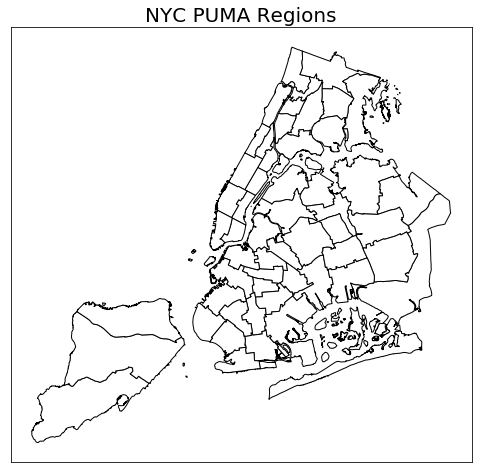

In [10]:
# plot NYC PUMA regions 
ax = pumashp.plot(figsize=(15,8), alpha=1, color='white', edgecolor='black')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('NYC PUMA Regions', fontsize=20)
ax.set_aspect(1.25)

Figure 1: NYC PUMA Regions. This map shows the countours of Public Use Microdata Area (PUMA) NYC regions. From the map, we can see that there is a lot of variability in the size and shape of PUMAs in NYC. PUMAs in Manhattan are relatively rectangular and regularly shaped. PUMAs in Brooklyn and Queens are larger and have more variabiliy in shape. There are three only large PUMAs in Staten Island.

## 2. American Fact Finder data on percentage of houses with broadband internet access

## 2.1 Get data with American Fact Finder (AFF) API

In [11]:
# read in API key saved in censusAPI.py
from censusAPI import myAPI

In [12]:
#read in in the variables available. the info is in the 1 year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [13]:
aff1y.keys()

dict_keys(['variables'])

In [14]:
#turning things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))

We need two features: total number of households, and number of households with broadband access

In [15]:
# extracting variables of B28002 that contain "broadband" 
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [16]:
# keyword for number of households with broadband internet access 
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [17]:
# keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [18]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [19]:
# getting the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [20]:
# merge the datasets
pumaBB = pumaBB.merge(pumaPP, left_on='public use microdata area', right_on='public use microdata area', how='inner')
pumaBB.head()

,B28002_004E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_001E,NAME_y,state_y,Unnamed: 4_y
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,"St. Lawrence County PUMA, New York",36,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,"Warren & Washington Counties PUMA, New York",36,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,Oneida County (Central)--Greater Utica & Rome ...,36,NaN


In [21]:
# drop extra columns 
pumaBB.drop(['NAME_y', 'state_y', 'Unnamed: 4_x', 'Unnamed: 4_y'], axis=1, inplace=True)

In [22]:
# rename columns
pumaBB = pumaBB.rename(columns={'NAME_x':'NAME', 'state_x':'state', 'public use microdata area':'puma'})

In [23]:
pumaBB.head()

,B28002_004E,NAME,state,puma,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [24]:
# generate a feature for the percentage of households with broadband access
pumaBB['B28002_004E'] = pumaBB['B28002_004E'].astype(int)
pumaBB['B28002_001E'] = pumaBB['B28002_001E'].astype(int)
pumaBB['public use microdata area'] = pumaBB['puma'].astype(int)
pumaBB['pcBB'] = pumaBB['B28002_004E'] / pumaBB['B28002_001E'] * 100
pumaBB.head()

,B28002_004E,NAME,state,puma,B28002_001E,public use microdata area,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,100,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,200,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,300,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,401,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,402,78.150656


##  2.3 Compare it with the AFF published "percentage of households with broadband access"

Move the GCT2801 file to jupyterhub/compute via sftp

In [25]:
#import os
#curPath = os.path.abspath('.')
#print(curPath)

In [26]:
#!unzip /nfshome/em3932/PUIdata/ACS_16_1YR_GCT2801.ST50.zip

# put zip in hw folder 

In [27]:
# # uploaded the file to folder via SFTP. read the data into a pandas dataframe
bbpc = pd.read_csv('ACS_16_1YR_GCT2801.ST50.csv', encoding='latin-1')

In [28]:
# keep only the columns we need 
bbpc = bbpc[["GCT_STUB.target-geo-id2","HC01","HC02"]]

In [29]:
#bbpc['GCT_STUB.target-geo-id2']

In [30]:
#type(bbpc['GCT_STUB.target-geo-id2'][0])

In [31]:
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [32]:
# check that the percentage of households with broadband I calculated is the same as reported by AFF 
bbpc['gid'] = (bbpc['GCT_STUB.target-geo-id2'] - 3600000).astype(int)
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="puma")[["pcBB", "HC01"]]
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


## 3. Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [33]:
# Add percentage of households with broadband access to shapefile
pumashp['puma'] = pumashp['puma'].astype(int)
pumashp = pumashp.merge(pumaBB, on='puma')
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,B28002_001E,public use microdata area,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,42158,3701,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,3702,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,44329,3703,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,44476,3704,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,55953,4015,78.778618


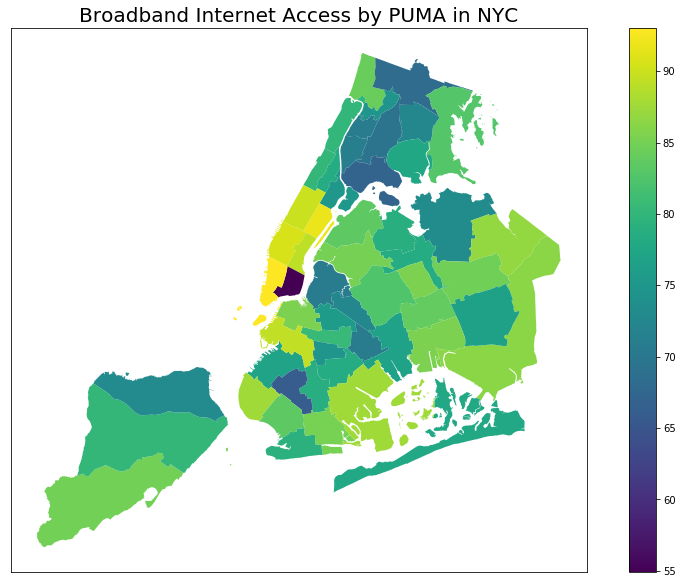

In [34]:
# Plot the choropleth 
f, ax = plt.subplots(figsize=(15,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp.plot(column='pcBB',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, legend=True, k=10)
plt.title("Broadband Internet Access by PUMA in NYC", fontsize=20)
ax.set_aspect(1.25)

Figure 2: Percentage of households with broadband internet access by PUMA in New York City. We can see that midtown and lower Manhattan in yellow have the highest percentage of households with broadband internet access (around 90%). One region of Manhattan on the lower east side in dark purple has the lowest percentage of households with broadband internet access. This is interesting and seems like an anomaly. Throughout the Bronx, the percentage of households with broadband internet access (between 55% and 65%) is relatively low when compared with the rest of the city. 

## 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [35]:
# read the Link NYC data into a Pandas df 
linkNYC = pd.read_csv('linkNYClocations.csv')
linkNYC.drop(['Unnamed: 0'], axis=1, inplace=True)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [36]:
linkNYC.shape

(1414, 4)

In [37]:
from geopandas.tools import sjoin
# Combine lat and lon to one column in a tuple
linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [38]:
# Sort by pcBB 
pumashp = pumashp.sort_values(['pcBB'])
pumashp = pumashp.reset_index(drop=True)
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,B28002_001E,public use microdata area,pcBB
0,3809,4.869347e+07,35299.804402,(POLYGON ((-73.98237340572007 40.7055433504376...,41821,NYC-Manhattan Community District 3--Chinatown ...,36,76131,3809,54.932945
1,4014,8.768042e+07,51089.073159,"POLYGON ((-73.9781907435932 40.64752599151113,...",27834,NYC-Brooklyn Community District 12--Borough Pa...,36,42114,4014,66.092036
2,3710,1.377966e+08,91086.012338,(POLYGON ((-73.89680883223774 40.7958084451597...,35410,NYC-Bronx Community District 1 & 2--Hunts Poin...,36,52756,3710,67.120328
3,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,3702,68.310015
4,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,58706,3705,69.425612


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


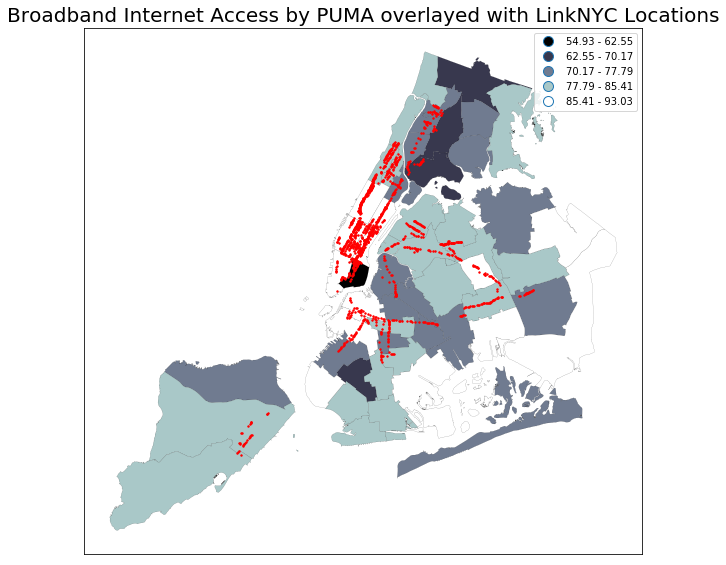

In [39]:
# Plot the choropleth with linkNYC locations overlayed 
linkNYC = gpd.GeoDataFrame(linkNYC)
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp.plot(column='pcBB',cmap='bone',edgecolor='black',alpha=1,linewidth=0.1,ax=ax, scheme="Equal_interval", legend=True, k=5)
linkNYC.plot('lonlat', ax=ax, color='red', markersize=2)
plt.title("Broadband Internet Access by PUMA overlayed with LinkNYC Locations", fontsize=20)
ax.set_aspect(1.25)

Figure 3: Percentage of households with broadband internet access by PUMA overlayed with LinkNYC locations. The LinkNYC locations are indicated by red dots. We see that the majority of the LinkNYC locations are distributed throughout Manhattan, where percentage of households with broadband internet access is highest. There are LinkNYC locations distributed throughout Brooklyn and Queens as well. There are very few locations in Staten Island. LinkNYC is lacking in some areas of the Bronx where the percentage of the households with broadband internet access is the lowest (between 55 and 63%).

## 5. Find the number of linkNYC locations per person by PUMA

In [40]:
# getting the total population
keyNpop = 'B00001_001E'
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNpop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [41]:
# convert lat/lon to flat coordinates
linkNYC.crs = from_epsg(4326)
linkNYC_ft = linkNYC.to_crs(epsg=2263)
pumashpa_ft = pumashp.to_crs(epsg=2263)

In [42]:
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,B28002_001E,public use microdata area,pcBB
0,3809,4.869347e+07,35299.804402,(POLYGON ((-73.98237340572007 40.7055433504376...,41821,NYC-Manhattan Community District 3--Chinatown ...,36,76131,3809,54.932945
1,4014,8.768042e+07,51089.073159,"POLYGON ((-73.9781907435932 40.64752599151113,...",27834,NYC-Brooklyn Community District 12--Borough Pa...,36,42114,4014,66.092036
2,3710,1.377966e+08,91086.012338,(POLYGON ((-73.89680883223774 40.7958084451597...,35410,NYC-Bronx Community District 1 & 2--Hunts Poin...,36,52756,3710,67.120328
3,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,49817,3702,68.310015
4,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,58706,3705,69.425612


In [43]:
# merge population into pumshp
pumashp = pumashp.merge(pumaPop, left_on='public use microdata area',right_on='public use microdata area',how='inner')
pumashp.drop(['NAME_x', 'state_x', 'public use microdata area','NAME_y', 'state_y', 'Unnamed: 4'],axis=1, inplace=True)
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,B28002_001E,pcBB,B00001_001E
0,3809,4.869347e+07,35299.804402,(POLYGON ((-73.98237340572007 40.7055433504376...,41821,76131,54.932945,1794
1,4014,8.768042e+07,51089.073159,"POLYGON ((-73.9781907435932 40.64752599151113,...",27834,42114,66.092036,2928
2,3710,1.377966e+08,91086.012338,(POLYGON ((-73.89680883223774 40.7958084451597...,35410,52756,67.120328,2004
3,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,49817,68.310015,1959
4,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,40757,58706,69.425612,2011


In [44]:
# get the number of link sites per puma 
linkpp = gpd.sjoin(linkNYC_ft, pumashpa_ft, how='inner')
linkpp = linkpp[['puma', 'link_site']]
linkpp = linkpp.groupby('puma').count()
linkpp = linkpp.reset_index()
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [45]:
# merge back into pumashp 
pumashp = pumashp.merge(linkpp, on='puma', how='outer')
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,B28002_001E,pcBB,B00001_001E,link_site
0,3809,4.869347e+07,35299.804402,(POLYGON ((-73.98237340572007 40.7055433504376...,41821,76131,54.932945,1794,62.0
1,4014,8.768042e+07,51089.073159,"POLYGON ((-73.9781907435932 40.64752599151113,...",27834,42114,66.092036,2928,NaN
2,3710,1.377966e+08,91086.012338,(POLYGON ((-73.89680883223774 40.7958084451597...,35410,52756,67.120328,2004,19.0
3,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,49817,68.310015,1959,NaN
4,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,40757,58706,69.425612,2011,1.0


In [46]:
# linkNYC per 100 inhabitants
pumashp['linkNYCp100p'] = (pumashp['link_site'] / pumashp['B00001_001E'] * 100)
pumashp['linkNYCp100p'].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

In [47]:
# sort by linkNYCp100p
pumashp = pumashp.sort_values('linkNYCp100p')
pumashp = pumashp.reset_index()
#pumashpa_ft.head()

## Plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


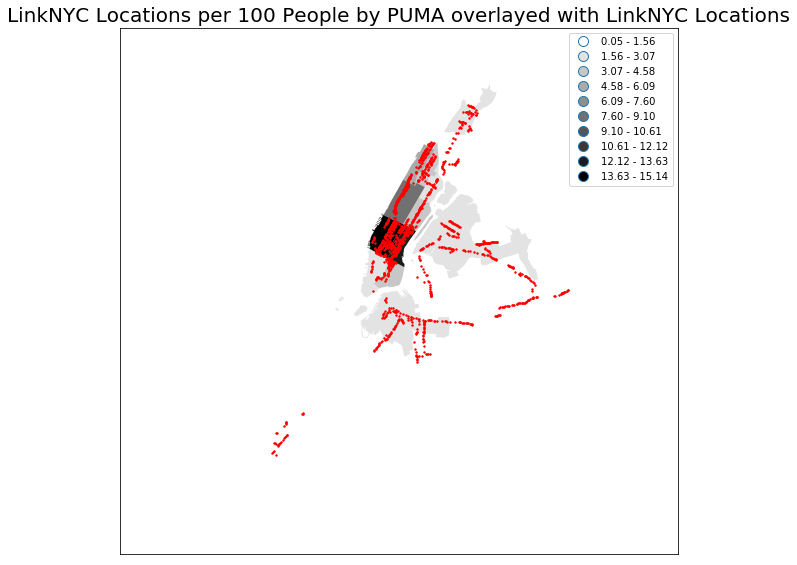

In [48]:
# plot linkNYC locations on top of a choropleth 
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp.plot(column='linkNYCp100p',cmap='gist_gray_r',linewidth=0.1,ax=ax,scheme="Equal_interval", legend=True, k=10)
#pumashp.plot(column='linkNYCp100p',cmap='gist_gray_r',alpha=1,linewidth=0.1,ax=ax, scheme="Equal_interval", legend=True, k=10)
linkNYC.plot('lonlat', ax = ax, color='red', markersize=2)
plt.title("LinkNYC Locations per 100 People by PUMA overlayed with LinkNYC Locations", fontsize=20)
ax.set_aspect(1.25)

Figure 4: Choropleth of number of LinkNYC locations per 100 residents overlayed by LinkNYC locations (red dots). We see that the highest number of LinkNYC locations are in Manhattan, where there is also the highest number of LinkNYC locations per 100 residents (around 12 or 13 locations per 100 residents in midtown and upper Manhattan). Almost everywhere else (the Bronx, Brooklyn, Queens, Staten Island) there are a much lower number of LinkNYC locations per 100 residents - between 0 and 6 locations per 100 residents. 

I do not know why the scale of this map changed to be incorrect for the outline of NYC and the boroughs. I used the same code as my previous choropleth, and I'm not sure why this has changed. 